<a href="https://colab.research.google.com/github/KarthikeyanBaskaran/StockPrediction/blob/main/Capstone_Microsoft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Standard Practices

import pandas as pd
import datetime
import matplotlib.pyplot as plt

#YahooFinance
import yfinance as yf

#Statsmodels
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot


import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings("ignore")


importing the dataset from yfinance

In [ ]:
# # Importing the dataset

# symbol = 'GOOG'

# df = yf.download(symbol, period="max", interval="1d")
# df.to_csv("GOOG.csv")

[*********************100%***********************]  1 of 1 completed


In [25]:
GOOG = pd.read_csv("https://raw.githubusercontent.com/KarthikeyanBaskaran/StockPrediction/refs/heads/main/GOOG.csv")
GOOG = GOOG[2:]
GOOG = GOOG.reset_index()
GOOG = GOOG.drop(columns=["index"])
GOOG = GOOG.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
GOOG[columns_to_convert] = GOOG[columns_to_convert].astype(float)
GOOG['Date'] = pd.to_datetime(GOOG['Date'])
GOOG['Volume'] = GOOG['Volume'].astype(int)
GOOG.head()

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512


In [26]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5186 non-null   datetime64[ns]
 1   Close   5186 non-null   float64       
 2   High    5186 non-null   float64       
 3   Low     5186 non-null   float64       
 4   Open    5186 non-null   float64       
 5   Volume  5186 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 243.2 KB


In [78]:
# df = GOOG[(GOOG['Date'] >= datetime(2020, 1, 1)) & (GOOG['Date'] <= datetime(2025, 1, 31))].reset_index(drop=True)
df = GOOG[GOOG['Date'] >= datetime(2020, 1, 1)].reset_index(drop=True)


prices = df[['Close','Date']]
prices = prices[prices['Date']<= datetime(2025, 1, 31)]
prices = prices.set_index('Date')

actual = df[df['Date']> datetime(2025, 1, 31)].reset_index(drop=True)


### EDA

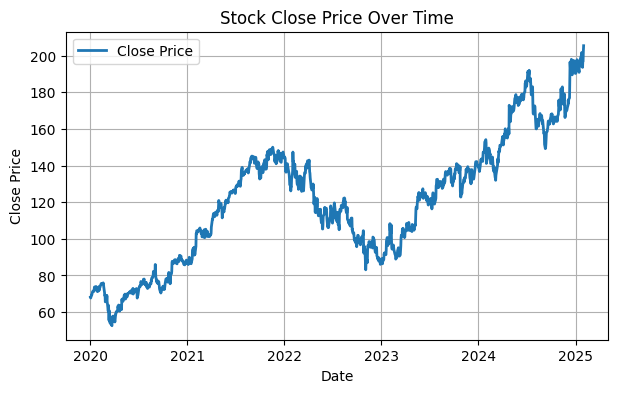

In [51]:
# Plot the Close price
plt.figure(figsize=(7, 4))
plt.plot(prices, linewidth=2, label="Close Price")

# Chart formatting
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Close Price Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()

### ARIMA

####Hypothesis testing:
null hypothesis: The stock is stationary

In [52]:
#Order of integration: Augmented Dickey-Fuller Test
adf = adfuller(x=prices['Close'], autolag='BIC')
print("The adf statistics is", format(adf[0], ".2f"))
print("The p value is",format(adf[1], ".2f"))

The adf statistics is -0.45
The p value is 0.90


Since p-value is more than 0.05 null hypothesis is rejected and the values are not stationary

#### ACF - Auto Correlation Function


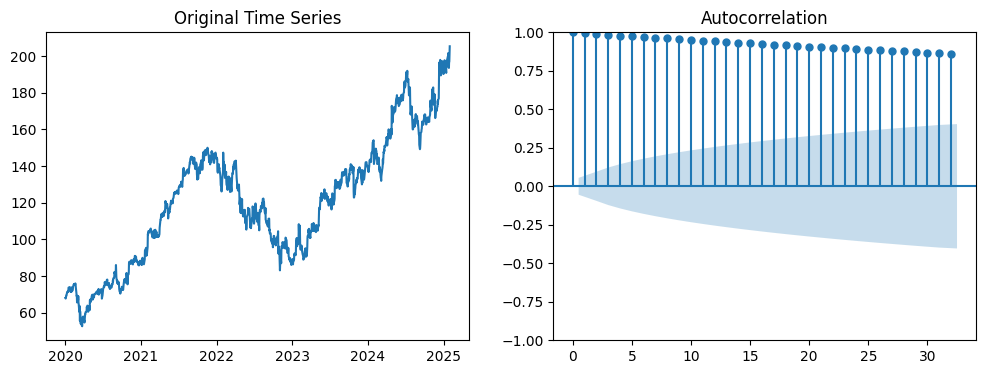

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(prices['Close'])
ax1.set_title('Original Time Series')
plot_acf(prices['Close'],ax=ax2);

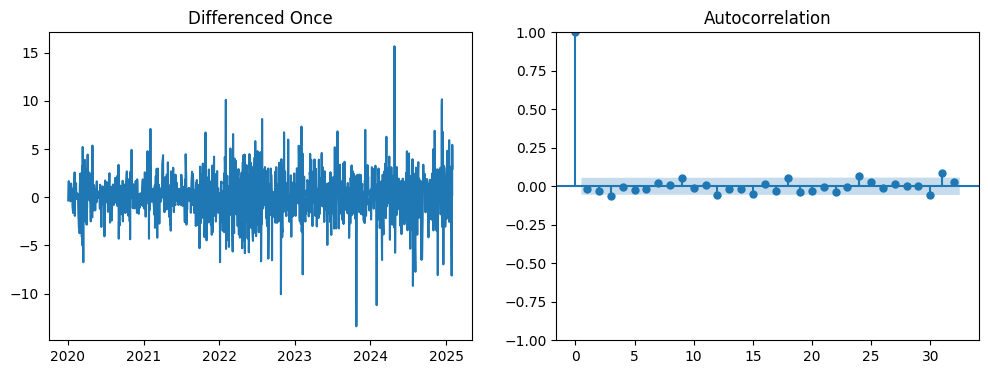

In [54]:
diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_acf(diff,ax=ax2);

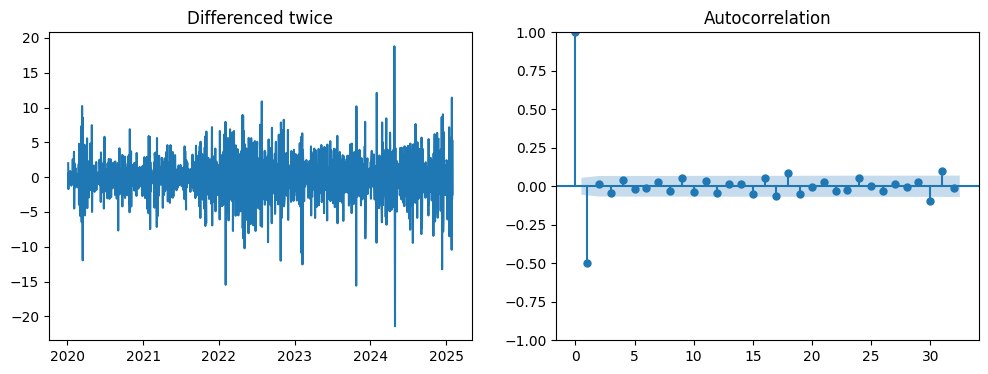

In [55]:
diff = prices.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced twice')
plot_acf(diff,ax=ax2);

No bigger difference when differencing twice so selecting "order of differencing" as once and q = 8

p

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

(0.0, 1.0)

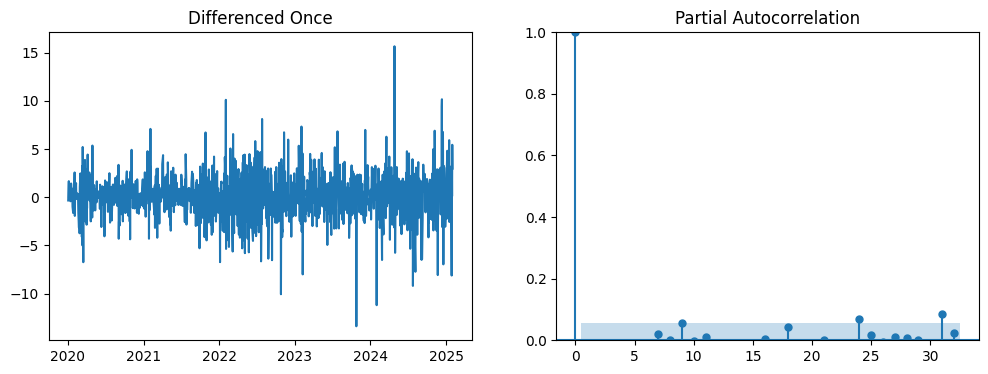

In [56]:
#p

diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_pacf(diff,ax=ax2);
ax2.set_ylim(0,1)

We observe PACF lag 31 based on the plot

In [38]:
# Compute returns
returns = prices.pct_change().dropna()

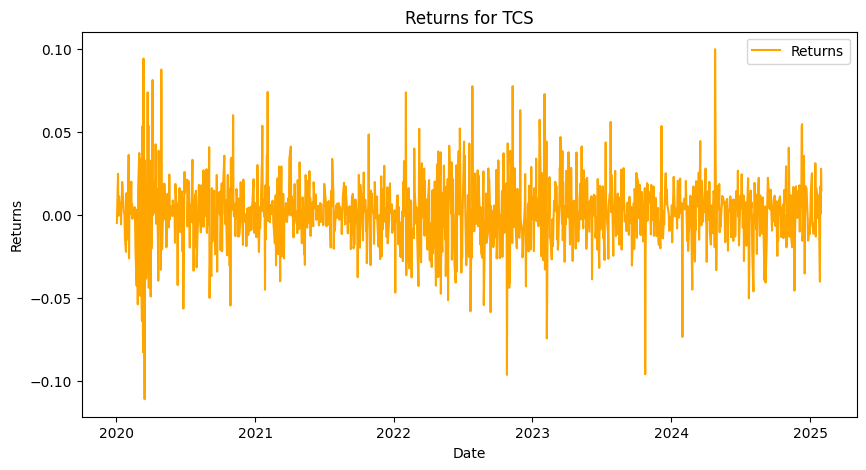

In [39]:
# Plot returns
plt.figure(figsize=(10, 5))
plt.plot(returns.index, returns, label='Returns', color='orange')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns for TCS')
plt.legend()
plt.show()


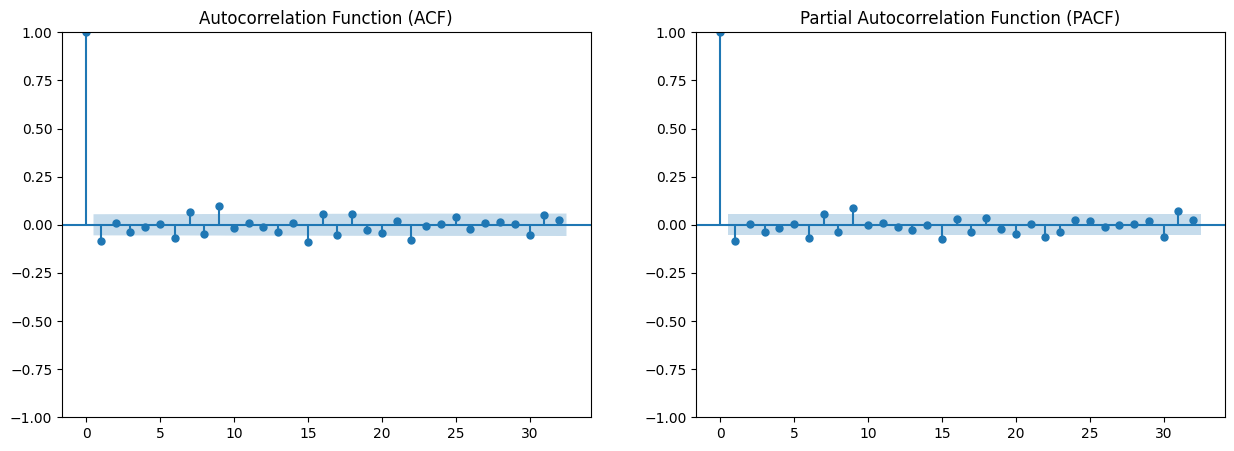

In [40]:

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(returns, ax=axes[0])
plot_pacf(returns, method='ywm', ax=axes[1])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

In [41]:
# Build ARIMA model (randomly chosen order, tuning required for better results)
model = ARIMA(prices, order=(31,1,8))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1278
Model:                ARIMA(31, 1, 8)   Log Likelihood               -2867.743
Date:                Wed, 02 Apr 2025   AIC                           5815.486
Time:                        23:46:57   BIC                           6021.577
Sample:                             0   HQIC                          5892.881
                               - 1278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0683      0.366      0.187      0.852      -0.649       0.785
ar.L2          0.2041      0.288      0.708      0.479      -0.361       0.769
ar.L3          0.2364      0.283      0.835      0.4

In [68]:
# Predict next 100 days' prices with 95% confidence interval
forecast = model_fit.get_forecast(steps=len(actual), alpha=0.05)
predicted_prices = forecast.predicted_mean

In [69]:
# Get predicted price for the next day
next_day_price = predicted_prices.iloc[0]
print(f"Predicted stock price for tomorrow: {next_day_price:.2f}")


Predicted stock price for tomorrow: 206.92


In [74]:
last_date = prices.index[-1]  # If 'Date' is set as index
print(last_date)


2025-01-31 00:00:00


In [75]:
predicted_dates = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=len(actual), freq='D')
predicted_dates

DatetimeIndex(['2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04',
               '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-08',
               '2025-02-09', '2025-02-10', '2025-02-11', '2025-02-12',
               '2025-02-13', '2025-02-14', '2025-02-15', '2025-02-16',
               '2025-02-17', '2025-02-18', '2025-02-19', '2025-02-20',
               '2025-02-21', '2025-02-22', '2025-02-23', '2025-02-24',
               '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28',
               '2025-03-01', '2025-03-02', '2025-03-03', '2025-03-04',
               '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-08',
               '2025-03-09', '2025-03-10', '2025-03-11', '2025-03-12'],
              dtype='datetime64[ns]', freq='D')

In [77]:
actual.head()

,Date,Close,High,Low,Open,Volume
0,2025-01-31,205.366043,206.844355,203.348337,203.483178,17087300
1,2025-02-03,202.409393,204.986459,201.430513,201.984874,16719500
2,2025-02-04,207.473633,208.462496,204.027547,204.267279,28285400
3,2025-02-05,193.080032,194.328610,189.693891,192.880263,43666400
4,2025-02-06,193.090012,193.609424,190.273229,190.772660,20816600


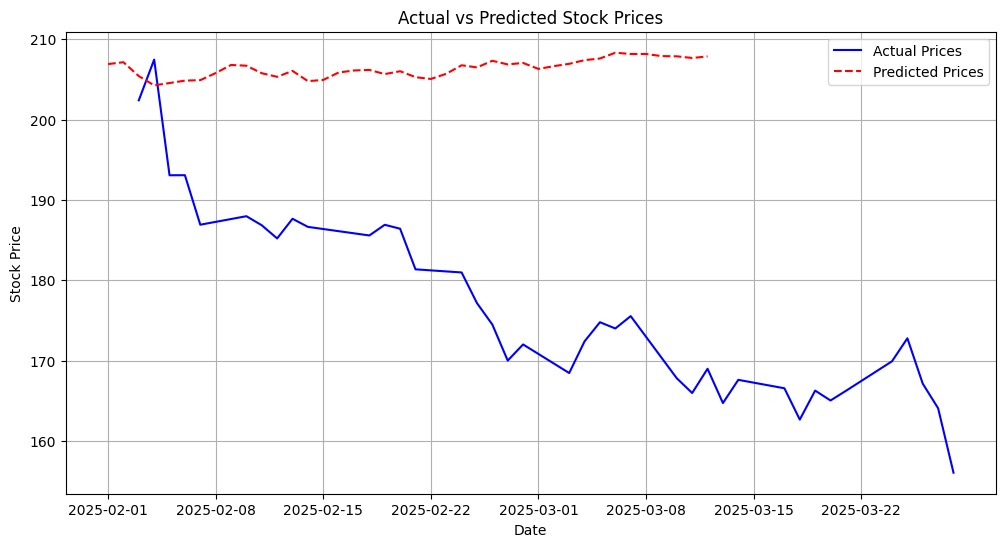

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')

# Plot predicted stock prices
plt.plot(predicted_dates, predicted_prices, label="Predicted Prices", color='red', linestyle='dashed')

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()

# Show plot
plt.show()